# Import Libraries

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string 
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# from keras.models import Sequential
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import pickle 


In [194]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [195]:
# read csv file into pandas
df = pd.read_csv("../datasets/question1.csv")
df.head(10)

,question_id,answer,grade
0,1,فترة الخلافة العباسية في الشرق,0
1,1,من 789م إلى 974 م,2
2,1,ما بين 645م و 725م,0
3,1,من 789م إلى نهاية 974 م,2
4,1,من 489م إلى 578 م,0
5,1,من 789م إلى 978 م,1
6,1,من العام 789 إلى العام 974 ميلادية، قامت سلالة...,2
7,1,من 589م إلى 878 م,0
8,1,من 891م إلى 974 م,1
9,1,من 789 - 974 م,2


# EDA

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  143 non-null    int64 
 1   answer       143 non-null    object
 2   grade        143 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [197]:
df.groupby('grade').size()

grade
0    44
1    49
2    50
dtype: int64

In [198]:
df.duplicated().sum()

7

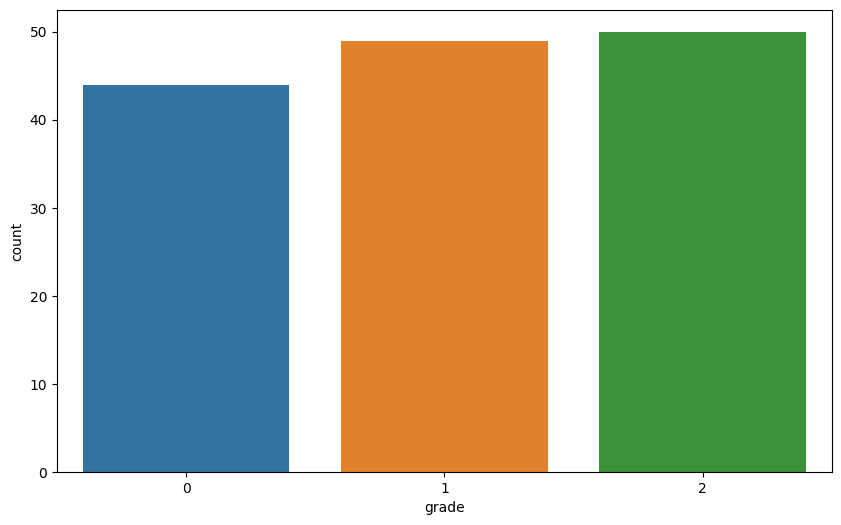

In [199]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()

# Data Cleaning

In [200]:
df.drop('question_id', axis=1, inplace=True)

In [201]:
df.dropna(inplace=True)

In [202]:
df.drop_duplicates(inplace=True)

# Data Pre-Preocessing

In [203]:
def txt_preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    return tokens

In [204]:
df['tokens'] = df['answer'].apply(txt_preprocess)

# Text Representation

In [205]:
model_word2vec = Word2Vec(df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

In [206]:
def get_word_vector(tokens, model_word2vec):
    textvector = np.zeros((100,), dtype='float32')
    for token in tokens:
        try:
            textvector += model_word2vec.wv[token]
        except KeyError:
            continue
    return textvector


df['textvector'] = df['tokens'].apply(lambda x: get_word_vector(x, model_word2vec))

In [207]:
df.head()

,answer,grade,tokens,textvector
0,فترة الخلافة العباسية في الشرق,0,"[فترة, الخلافة, العباسية, في, الشرق]","[0.008906784, 0.016161785, -0.0069208504, 0.01..."
1,من 789م إلى 974 م,2,"[من, 789م, إلى, 974, م]","[-0.024728881, 0.022663996, -0.0056508826, 0.0..."
2,ما بين 645م و 725م,0,"[ما, بين, 645م, و, 725م]","[0.0014935606, 0.0206845, 0.010706747, -0.0138..."
3,من 789م إلى نهاية 974 م,2,"[من, 789م, إلى, نهاية, 974, م]","[-0.027277961, 0.016967036, 0.0018776967, 0.00..."
4,من 489م إلى 578 م,0,"[من, 489م, إلى, 578, م]","[-0.03036443, 0.007394391, 0.01106086, 0.00513..."


# split the data

In [208]:
train_data = df.sample(frac=0.85, random_state=42)
test_data = df.drop(train_data.index)

In [209]:
X_train = np.array(train_data['textvector'].tolist())
Y_train = np.array(train_data['grade'])

X_test = np.array(test_data['textvector'].tolist())
Y_test = np.array(test_data['grade'])
print(X_test)

[[ 0.00149356  0.0206845   0.01070675 ...  0.00589834  0.00451167
   0.00257529]
 [-0.01401338  0.00602183  0.01244089 ...  0.00450731  0.00139775
   0.02129978]
 [-0.01941218  0.01162673  0.01901562 ... -0.00316519  0.00018923
  -0.01269813]
 ...
 [-0.00640177 -0.02298243 -0.03585386 ... -0.0087773   0.02983079
   0.02850741]
 [-0.0789667   0.06218586  0.03875328 ... -0.06853679  0.01044347
  -0.09734043]
 [-0.0308928   0.02089188  0.02144409 ... -0.02839797  0.01008177
  -0.0318289 ]]


# build Models 

In [210]:
def getModel(name):
    if name == 'svm_linear':
        model_svm_linear = SVC(kernel='linear' ,probability=True)
        model_svm_linear.fit(X_train, Y_train)
        return model_svm_linear
    elif name == 'svm_rbf':
        model_svm_rbf = SVC(kernel='rbf' , probability=True)
        model_svm_rbf.fit(X_train, Y_train)
        return model_svm_rbf
    elif name == 'random_forest':
        model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        model_rf.fit(X_train, Y_train)
        return model_rf
    elif name == 'knn':
        model_knn = KNeighborsClassifier(n_neighbors=15)
        model_knn.fit(X_train, Y_train)
        return model_knn
    elif name == 'naive_bayes':
        model_nb = GaussianNB()
        model_nb.fit(X_train, Y_train)
        return model_nb
    elif name == 'bagging':
        # Créer le modèle de base
        base_model = DecisionTreeClassifier()
        model_bagging = BaggingClassifier(base_estimator=base_model, n_estimators=10, random_state=42)
        # Entraîner le modèle Bagging
        model_bagging.fit(X_train, Y_train)
        return model_bagging
    elif name == 'ann':
        # MLP: création + entrainement
        model_ANN = MLPClassifier(hidden_layer_sizes=(15, 10), random_state=1, max_iter=800)
        model_ANN.fit(X_train , Y_train)
        return model_ANN
    elif name == 'decision_tree':
        model_dt = DecisionTreeClassifier()
        model_dt.fit(X_train, Y_train)
        return model_dt
    else:
        raise ValueError("Invalid model name. Please choose from 'svm', 'random_forest', 'knn', or 'naive_bayes'.")


In [211]:
# construire le model 
model_svm_lin = getModel('svm_linear')
# predire les donnees de Test
Y_pred_svm_lin = model_svm_lin.predict_proba(X_test)

In [212]:
# construire le model 
model_svm_rbf = getModel('svm_rbf')
# predire les donnees de Test
Y_pred_svm_rbf = model_svm_rbf.predict_proba(X_test)

In [213]:
# construire le model 
model_rf = getModel('random_forest')
# predire les donnees de Test
Y_pred_rf = model_rf.predict_proba(X_test)

In [214]:
# construire le model 
model_knn = getModel('knn')
# predire les donnees de Test
Y_pred_knn = model_knn.predict_proba(X_test)

In [215]:
# construire le model 
model_nb = getModel('naive_bayes')
# predire les donnees de Test
Y_pred_nb = model_nb.predict_proba(X_test)

In [216]:
# construire le model 
model_ann = getModel("ann")
# predire les donnees de Test
Y_pred_ann = model_ann.predict_proba(X_test)

In [217]:
# construire le model 
model_bagging  = getModel('bagging')
# predire les donnees de Test
Y_pred_bagging = model_bagging.predict_proba(X_test)

In [218]:
# construire le model 
model_dt  = getModel('decision_tree')
# predire les donnees de Test
Y_pred_dt = model_dt.predict_proba(X_test)

# Models Evaluation

In [219]:
models = [
  getModel('svm_linear'),
  getModel('svm_rbf'),
  getModel('random_forest'),
  getModel('knn'),
  getModel('naive_bayes'),
  getModel("ann"),
  getModel('bagging'),
  getModel('decision_tree')
]
models_names = [
    'SVM Linear',
    'SVM RBF',
    'Random Forest',
    'KNN',
    'Naive Bayes',
    'ANN',
    'Ensemble Learning (Bagging)',
    'Decision Tree'
]
predicted_Xtest_proba = [
    Y_pred_svm_lin,
    Y_pred_svm_rbf,
    Y_pred_rf,
    Y_pred_knn,
    Y_pred_nb,
    Y_pred_ann,
    Y_pred_bagging,
    Y_pred_dt
]

In [220]:
def getAccuracy(models):
  accuracies = []
  for model in models:
    Y_Test_predi = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_Test_predi)
    accuracies.append(accuracy)

  return accuracies

In [221]:
accuracies = getAccuracy(models)
i=0
for model in models_names:
    print(f"accuracy {model} :  {accuracies[i]}")
    i += 1

accuracy SVM Linear :  0.35
accuracy SVM RBF :  0.8
accuracy Random Forest :  0.7
accuracy KNN :  0.65
accuracy Naive Bayes :  0.65
accuracy ANN :  0.8
accuracy Ensemble Learning (Bagging) :  0.6
accuracy Decision Tree :  0.45


In [222]:
i=0
for  Y_test_pred_prob in predicted_Xtest_proba:
#     Y_test_pred = Y_test_pred.reshape(-1, 1)
    auc_roc = roc_auc_score(Y_test, Y_test_pred_prob , multi_class='ovr')
    print(f"{models_names[i]}  Aire sous la courbe ROC:", auc_roc)
    i += 1

SVM Linear  Aire sous la courbe ROC: 0.7455357142857141
SVM RBF  Aire sous la courbe ROC: 0.9097222222222222
Random Forest  Aire sous la courbe ROC: 0.8663194444444445
KNN  Aire sous la courbe ROC: 0.8296130952380952
Naive Bayes  Aire sous la courbe ROC: 0.8492063492063492
ANN  Aire sous la courbe ROC: 0.9126984126984127
Ensemble Learning (Bagging)  Aire sous la courbe ROC: 0.8645833333333334
Decision Tree  Aire sous la courbe ROC: 0.6994047619047619


# the best Model

In [223]:
max_index = np.argmax(accuracies)
best_model = models[max_index]

In [224]:
pd.DataFrame({"Real ": Y_test , "Predicted" : best_model.predict(X_test)})

,Real,Predicted
0,0,0
1,0,1
2,1,1
3,0,2
4,2,2
5,0,0
6,2,2
7,1,1
8,2,2
9,1,0


# saving the best model

In [239]:
model_path = '../saved_models/model_question1.h5'
with open(model_path, 'wb') as file:
    pickle.dump((model_svm_rbf, model_word2vec), file)

# Test Model

In [238]:
answer = 'من 785 الى  975'
process = txt_preprocess(answer)
txt = get_word_vector(process, model_word2vec)
txt = txt.reshape(1, -1)

i=0
for model in models_names:
    predicted_ques = models[i].predict(txt)[0]
    print(f" {model} :  {predicted_ques}")
    i += 1

 SVM Linear :  1
 SVM RBF :  1
 Random Forest :  1
 KNN :  1
 Naive Bayes :  1
 ANN :  1
 Ensemble Learning (Bagging) :  1
 Decision Tree :  1
